<a href="https://colab.research.google.com/github/qiopta/MADSm2/blob/main/Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1 - Getting the environment set, including colab based IDE

In [ ]:
#!pip install colabcode

In [ ]:
#from colabcode import ColabCode #not needed as uVM for IDE based bert
import pandas as pd
import zipfile
import numpy as np
from collections import Counter
#from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler #doesnt work on sparse matrices
from sklearn.preprocessing import MaxAbsScaler #therefore using this
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import re
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection

RANDOM_SEED = 42

In [ ]:
# !pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"qiopta","key":"64b826e59c2b570f04f47f4020f2d923"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#ColabCode(port=10000, password = 'Qiopta', mount_drive=True)

# Section 2 - Notes for the IDE environment

Download the UMICH data from Kaggle with:

!kaggle competitions download -c umich-siads-695-predicting-text-difficulty

# Section 3 Local Colab analysis, upload datasets create train/test dfs

In [ ]:
!kaggle competitions download -c umich-siads-695-predicting-text-difficulty

  0% 0.00/278k [00:00<?, ?B/s]
100% 278k/278k [00:00<00:00, 27.7MB/s]
  0% 0.00/834k [00:00<?, ?B/s]
100% 834k/834k [00:00<00:00, 55.2MB/s]
 44% 9.00M/20.3M [00:01<00:01, 7.68MB/s]
100% 20.3M/20.3M [00:01<00:00, 13.2MB/s]
  0% 0.00/2.83k [00:00<?, ?B/s]
100% 2.83k/2.83k [00:00<00:00, 2.47MB/s]
100% 4.73M/4.73M [00:00<00:00, 11.1MB/s]

  0% 0.00/410k [00:00<?, ?B/s]
100% 410k/410k [00:00<00:00, 57.1MB/s]
  0% 0.00/18.3k [00:00<?, ?B/s]
100% 18.3k/18.3k [00:00<00:00, 19.7MB/s]


In [ ]:
!ls

additional_resource_file_readme.txt		  sample_data
AoA_51715_words.csv.zip				  sampleSubmission.csv.zip
Concreteness_ratings_Brysbaert_et_al_BRM.txt.zip  WikiLarge_Test.csv.zip
dale_chall.txt					  WikiLarge_Train.csv.zip
kaggle.json


In [ ]:
zf = zipfile.ZipFile('/content/WikiLarge_Train.csv.zip') 
train_df = pd.read_csv(zf.open('WikiLarge_Train.csv'))

In [ ]:
zf = zipfile.ZipFile('/content/WikiLarge_Test.csv.zip') 
test_df = pd.read_csv(zf.open('WikiLarge_Test.csv'))

In [ ]:
tenK_train = train_df.sample(10000)
onehK_train = train_df.sample(100000)
twohK_train = train_df.sample(200000)

## Vectorize the the training data, note tenK sample size baseline, labels will need to match when training classifiers

In [ ]:
%%time
#This needs vectorizing to work
vectorizer = TfidfVectorizer(min_df = 100, stop_words ='english', ngram_range = (1, 2)) #experiment unigrams (most defaults in this set were tested with min-df =100 and ngrams (1,2), best looks to be 25 (1,2))
X_train    = vectorizer.fit_transform(tenK_train['original_text'])
vec_test   = vectorizer.transform(test_df['original_text']) 
# takes 30 secs on CPU runtime for full data, 767ms for 10K, 50K took 2.5 s, trying 100K took 5.5 secs, 200K takes 10 secs. With 2 bigrams (now with test set inc takes c.5secs for 10K)
# Get shuffle split params set up
shuff_spt = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=10)

CPU times: user 4.07 s, sys: 34.7 ms, total: 4.1 s
Wall time: 4.14 s


#Section 4 Dummy classifier, baseline classifiers with minimal pre-processing AND GBT classifier in this section

In [ ]:
# split train into dev set(s)
# for dummy baseline clf using CV=5 cross validation score 

In [ ]:
mostf_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)

In [ ]:
scores = cross_val_score(mostf_clf, train_df.original_text, train_df.label, cv=5)

In [ ]:
scores.mean()

0.49999760056626635

In [ ]:
#comparison with stratified, shuffle and loo cv
loo = LeaveOneOut() #too time consuming for large dataset, better for smaller
shuff_spt = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=10)
scores = cross_val_score(mostf_clf, train_df.original_text, train_df.label, cv=shuff_spt)
scores #showing remarkable consistency, its balanced.

array([0.49977445, 0.49972647, 0.49914581, 0.49899704, 0.49870432,
       0.49979365, 0.4995729 , 0.49976966, 0.49976486, 0.49848837])

In [ ]:
mostf_clf.fit(train_df.original_text, train_df.label)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

In [ ]:
dclf_preds = mostf_clf.predict(test_df)

In [ ]:
len(dclf_preds)

119092

In [ ]:
test_df.shape

(119092, 3)

In [ ]:
dclf_preds[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
# Add id's to preds, write to CSV
dclf_pred_df = pd.DataFrame(data=dclf_preds).reset_index()
dclf_pred_df.columns = ['id', 'label']
dclf_pred_df.to_csv('dclf_preds.csv', index=False)

In [ ]:
#files.download('dclf_preds.csv') #this worked and was accepted by Kaggle as a submission

In [ ]:
#testing submission via API, this worked :-)
#!kaggle competitions submit umich-siads-695-predicting-text-difficulty -f dclf_preds.csv -m "Testing submission via Colab API, copy of dummy CLF result"

## Gradient boost decision tree

In [ ]:
GBDT_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=3, random_state=RANDOM_SEED)

Starting with only 10000 rows for baseline model, will need to shuffle the data to ensure I get balanced labels

In [ ]:
#Option fit and set sample weights to sub-set

In [ ]:
%%time
scores = cross_val_score(GBDT_clf, X_train, tenK_train.label, cv=shuff_spt) # a slice of 10000 takes 3.9 secs, 100K takes 95 secs.
scores

CPU times: user 3.67 s, sys: 9.69 ms, total: 3.68 s
Wall time: 3.68 s


In [ ]:
scores.mean() #suggests c.58% accuracy, will try to run on test set and make a submission, 58% on 10K, 60% on 100K could try CATboost to utilise GPU training. 

0.5688799999999998

In [ ]:
vec_test

<119092x81 sparse matrix of type '<class 'numpy.float64'>'
	with 201976 stored elements in Compressed Sparse Row format>

In [ ]:
%%time
GBDT_clf.fit(X_train, tenK_train.label) #took 20 secs for 100K


CPU times: user 693 ms, sys: 1.99 ms, total: 695 ms
Wall time: 701 ms


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
%%time
gb_preds = GBDT_clf.predict(vec_test)

CPU times: user 165 ms, sys: 955 µs, total: 166 ms
Wall time: 169 ms


In [ ]:
# # Add id's to preds, write to CSV
gb_clf_pred_df = pd.DataFrame(data = gb_preds).reset_index()
gb_clf_pred_df.columns = ['id', 'label']
gb_clf_pred_df.to_csv('gb_preds.csv', index=False)

In [ ]:
#!kaggle competitions submit umich-siads-695-predicting-text-difficulty -f gb_preds.csv -m "10K GBDT trained submit via Colab API, local CV gives 57%"

# Section 5 Logistic regresson classifier

In [ ]:
lr_clf = LogisticRegression(solver='lbfgs', random_state=42, max_iter=1000) #baseline hyparameters, could be worth running grid search for L2 etc. Do this on the 10K version, rather than the 100K :-)

In [ ]:
scores = cross_val_score(lr_clf, X_train, tenK_train.label, cv=shuff_spt) # 3.9 secs for 10K, very similar result, 7 secs for 100K with max iter 100 - 64%, trying max iter 1000 with 100K - still 64% but converged quickly
scores.mean() #66.17% on 200hk, using 10K for expermiments - baseline here is 55.798 but sometimes as high as 57.68% and LR is about as good as GBDT and faster (uni/bigrams best;  bi and trigrams worse) (min df 50 looks better by c.1%, 25 is 2% better)

0.5686599999999999

In [ ]:
X_train.shape

(10000, 87)

In [ ]:
#Function to remove brackets terms and re fit vec/clf run CV
cleaned_tenK_train = tenK_train.replace(to_replace ='-LRB-|-RRB-', value = '', regex = True)
X_train    = vectorizer.fit_transform(cleaned_tenK_train['original_text'])
scores = cross_val_score(lr_clf, X_train, cleaned_tenK_train.label, cv=shuff_spt) 
scores.mean()

0.55026

So removing brackets might help 'interpret' clusters/topics but actually weakens the classifier.

In [ ]:
#re-run vectorizer and scoring steps to check impact of pre-processing


In [ ]:
tenK_train.label.shape #an issue at 2000K training where X only has 1928 features and expects 3831 as above...

(10000,)

In [ ]:
%%time
lr_clf.fit(X_train, tenK_train.label)
lr_preds = lr_clf.predict(vec_test)
lr_clf_pred_df = pd.DataFrame(data = lr_preds).reset_index()
lr_clf_pred_df.columns = ['id', 'label']
lr_clf_pred_df.to_csv('lr_preds.csv', index=False)


CPU times: user 226 ms, sys: 4.95 ms, total: 231 ms
Wall time: 235 ms


In [ ]:
#!kaggle competitions submit umich-siads-695-predicting-text-difficulty -f lr_preds.csv -m "100K LR trained submit via Colab API, local CV gives 64% expected to be better than vanilla GBDT result, and did not converge so could increase max iterations from default next"

# Section 6 Initial scaling and unsupervised learning experiments
Based on LR clf using 10K vectorized examples.


* Scaling - MaxAbs, Standard, and Robust produce very little effect on the TFIDF vectorizes sparse matrix
* PCA
* Alternative vectorization
* Clustering




In [ ]:
lr_clf = LogisticRegression(solver='lbfgs', random_state = RANDOM_SEED, max_iter=1000)  #baseline hyparameters, could be worth running grid search for L2 etc. Do this on the 10K version)

scalers = [MaxAbsScaler(), StandardScaler(with_mean=False), RobustScaler(with_centering=False)]
for scaler in scalers:
  print ('For %scaler.' %scaler)
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  scores = cross_val_score(lr_clf, X_train_scaled, tenK_train.label, cv=shuff_spt) # 
  print ("Mean CV Score:                       ", scores.mean()) #Essentially no difference to unscaled
print ('The baseline unscaled LR CLF produced 0.55798')

For MaxAbsScaler(copy=True)caler.
Mean CV Score:                        0.56474
For StandardScaler(copy=True, with_mean=False, with_std=True)caler.
Mean CV Score:                        0.56206
For RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
             with_scaling=True)caler.
Mean CV Score:                        0.5611599999999999
The baseline unscaled LR CLF produced 0.55798


## Understanding PCA
X_train.shape # shows we have created 81 features by TFDIF Vectorizing (10,000, 81) the 'Original text' in the training data when sampling 10,000 rows.

From SKlearn: In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA)


In [ ]:
# # Do MaxAbsScaler first, as has best impact on accuracy
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_train) #not required for Truncated SVD
# Do fit/transform NOTE PCA does not support sparse input. See TruncatedSVD for a possible alternative.
tsvd = TruncatedSVD(n_components=8, random_state= RANDOM_SEED) # going with 10% of the features created by a 10K sample vectorized 
X_tsvd = tsvd.fit_transform(X_scaled) # toggle X_train &  X_scaled in experiments
#compare
print (X_tsvd.shape)

(10000, 8)


In [ ]:
X_tsvd[0]

array([ 3.73126677e-02,  1.62641512e-02,  4.11473296e-04,  8.91435487e-02,
        1.71415235e-01,  4.41418705e-01, -1.19893416e-01, -5.96791277e-02])

In [ ]:
X_train[0] #shows 76 Features here, so sample is not commonly seeded (ie today's 10K rows arent yesterdays 10K rows)

<1x84 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [ ]:
lr_clf = LogisticRegression(solver='lbfgs', random_state = RANDOM_SEED, max_iter=1000)  #baseline hyparameters, could be worth running grid search for L2 etc. Do this on the 10K version)
scores = cross_val_score(lr_clf, X_tsvd, tenK_train.label, cv=shuff_spt) # 
print ("Mean CV Score for T-SVD model:       ", scores.mean()) #obvs
print ('The baseline unscaled LR CLF produced 0.55798')

Mean CV Score for T-SVD model:        0.54208
The baseline unscaled LR CLF produced 0.55798


## Using K means to find clusters
Based on 543 Assignment two.  Measure of cluster quality to find optimal K in range from 2-9.  Then run the K clusters, and discover the mean centroid (typical sentence) for each cluster.


In [ ]:
%%time
#find optimal K, in k means clustering
for k in range(2,10):
    print ('_'*25, k)
    kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state=RANDOM_SEED)
    kmeans.fit(X_train)
    #print ('Shape of reshaped labels:', kmeans.labels_.reshape(-1,1).shape)
    #print ('Shape of reshaped labels after .ravel():', kmeans.labels_.reshape(-1,1).ravel().shape)
    print ('Davies Boulding   (should be low)  ', davies_bouldin_score(X_train.toarray(), kmeans.labels_.reshape(-1,1).ravel()))
    print ('Calinski Harabasz (should be high)', calinski_harabasz_score(X_train.toarray(), kmeans.labels_.reshape(-1,1).ravel()) )

_________________________ 2
Davies Boulding   (should be low)   1.957223081315819
Calinski Harabasz (should be high) 111.90020332520037
_________________________ 3
Davies Boulding   (should be low)   2.8078980771658215
Calinski Harabasz (should be high) 662.5526837787584
_________________________ 4
Davies Boulding   (should be low)   2.606389755111424
Calinski Harabasz (should be high) 205.9193558938128
_________________________ 5
Davies Boulding   (should be low)   2.4467202989922088
Calinski Harabasz (should be high) 193.57458665440305
_________________________ 6
Davies Boulding   (should be low)   2.2642491445387747
Calinski Harabasz (should be high) 204.97787233547197
_________________________ 7
Davies Boulding   (should be low)   2.1074865768187925
Calinski Harabasz (should be high) 401.94181190043093
_________________________ 8
Davies Boulding   (should be low)   1.6884034160012935
Calinski Harabasz (should be high) 406.0670699557539
_________________________ 9
Davies Boulding   

In [ ]:
# Start with 2 clusters for intelligbility of results
# Going to go with K=7 based on above
def kmeans_sentences(k, X):
    ''' Input k, number of clusters and training data
    returns k lists, each of which are the ten most highly weighted words in
    mean centriod of cluster'''
    
    #Specify and get model
    kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state= RANDOM_SEED)
    kmeans.fit(X)
    
    #find typical vector for each cluster (gets K X row shape)
    centers = kmeans.cluster_centers_
    
    #get f names
    f_names = vectorizer.get_feature_names()
    
    #compile k lists of strs within a dict, str for final terms, lst to iterate over and get terms using IDX's
    d = {}
    for i in range(k):
        d["cl" + str(i) + '_str'] = [] #empty list to capture list of strings
        cent_idx_s = centers.argsort()[i][-1:-6:-1] #gets Kth item and slices last six items (based on mean sent length analysis)
        d["cl" + str(i) + '_lst'] = list(cent_idx_s)  #previously was slice [i][10] first 10 items from cent idx variable change per iteration
    
    #get feature names for idxed items and compile list of lists as result
    result = []
    
    for i in range(k):
        for item  in d["cl" + str(i) + '_lst']:
            d["cl" + str(i) + '_str'].append(f_names[item])
        result.append(d["cl" + str(i) + '_str']) 
    
    return result

In [ ]:
list_centroids = kmeans_sentences(7, X_train)

In [ ]:
print ([list for list in list_centroids])

[['called', 'lrb', 'rrb', 'used', 'area'], ['south', 'west', 'east', 'north', 'located'], ['born', 'lrb born', 'rrb', 'lrb', 'football'], ['city', 'france', 'used', 'department', 'commune'], ['state', 'city', 'states', 'county', 'university'], ['people', 'lrb', 'rrb', 'commune', 'region'], ['rrb', 'lrb', 'lrb rrb', 'known', 'used']]


Need to ascertain average sentence length in X_train, as ten words in the centroid list may be too big

In [ ]:
len(tenK_train.iloc[0,0])

87

In [ ]:
tenK_train['word_count'] = tenK_train.original_text.apply(lambda x: len(str(x).split(' ')))

In [ ]:
tenK_train.head()

,original_text,label,word_count
408219,"Wolfgang Kleff -LRB- born 16 November , 1946 -...",0,16
392848,Tungsten -LRB- sometimes named wolfram -RRB- i...,0,25
188804,The headwaters are located on Mount Timpanogos...,1,17
140847,Saint-Sauveur-de-Puynormand is a commune in th...,1,14
192959,"Whether on land or in water , fire salamanders...",1,12


In [ ]:
#sanity check split
sample_sent = tenK_train.iloc[2,0]
print (sample_sent)

The headwaters are located on Mount Timpanogos and the river continues down through American Fork Canyon .


In [ ]:
tenK_train.describe()

,label,word_count
count,10000.00000,10000.000000
mean,0.50230,21.735600
std,0.50002,12.499677
min,0.00000,1.000000
25%,0.00000,13.000000
50%,1.00000,20.000000
75%,1.00000,29.000000
max,1.00000,80.000000


In [ ]:
#given mean sentence lengh of 22, 10 chars is about half the sentance, so going for 5 as smaller size. Edit function above 

In [ ]:
sample_sent[-1:-6:-1]

'. noy'

In [ ]:
# it seems that the brackets are messing up the purity of the clusters so removing them may give more distinctive cluster, but will it improve classifiers?...
# 7 Clusters with 5 top features looks to be about right, need to lose the RRB / LRB notation. So next step is some preprocessing....
# if the clustering above is post vectorizer, then need to re-do the sample, remove the unwanted terms RRB - LRB and any seperators, revectorise and repeat.

In [ ]:
#new sample 10K
new_10K_train  = train_df.sample(10000)

In [ ]:
new_10K_train.head()

,original_text,label
147920,The U.S. Census Bureau 2007 estimate for the c...,1
141327,"It was named in honor of Spencer Compton , the...",1
205320,RSS -LRB- most commonly translated as '' Reall...,1
408639,"Wayland is connected with Wayland 's Smithy , ...",0
237174,"At the end of the level , the player is awarde...",0


In [ ]:
brb_sent = new_10K_train.iloc[9,0]

In [ ]:
re.findall(r'-LRB-|-RRB-', brb_sent)

['-LRB-', '-RRB-']

In [ ]:
re.search('(-LRB-|-RRB-)', brb_sent)

<re.Match object; span=(5, 10), match='-LRB-'>

In [ ]:
regex_pattern = re.compile(r'-LRB-|-RRB-')

In [ ]:
#Function to remove these terms
cleaned_new_10K = new_10K_train.replace(to_replace ='-LRB-|-RRB-', value = '', regex = True)

In [ ]:
print (cleaned_new_10K.iloc[9,0])
print (brb_sent)

Dill  Anethum graveolens  is a short-lived perennial herb .
Dill -LRB- Anethum graveolens -RRB- is a short-lived perennial herb .


In [ ]:
# Worth inserting a step here that looks into different params for the Vectorizor and seeing how this impacts the quality of the clusters.

In [ ]:
cleanANDvec10K = vectorizer.fit_transform(cleaned_new_10K['original_text']) 

In [ ]:
list_centroids = kmeans_sentences(7, cleanANDvec10K)

In [ ]:
print ([list for list in list_centroids])

[['united', 'states', 'united states', 'city', 'county'], ['born', 'football', 'player', 'football player', 'american'], ['march', 'born', 'known', 'american', 'december'], ['known', 'city', 'called', 'new', 'time'], ['used', 'like', 'time', 'known', 'english'], ['france', 'department', 'commune', 'region', 'north'], ['world', 'war', 'known', 'june', 'including']]


In [ ]:
## Comparison to 10K sample with Brackets
lr_clf = LogisticRegression(solver='lbfgs', random_state = RANDOM_SEED, max_iter=1000)  #exact copy of baseline hyparameters on the 10K version)

scalers = [MaxAbsScaler(), StandardScaler(with_mean=False), RobustScaler(with_centering=False)]
for scaler in scalers:
  print ('For: ', scaler)
  scaler.fit(cleanANDvec10K)
  X_train_scaled = scaler.transform(cleanANDvec10K)
  scores = cross_val_score(lr_clf, X_train_scaled, new_10K_train.label, cv=shuff_spt) # 
  print ("Mean CV Score:                       ", scores.mean()) #Essentially no difference to unscaled
print ('The baseline unscaled LR CLF produced 0.55798')

For:  MaxAbsScaler(copy=True)
Mean CV Score:                        0.5599000000000001
For:  StandardScaler(copy=True, with_mean=False, with_std=True)
Mean CV Score:                        0.5569400000000001
For:  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
             with_scaling=True)
Mean CV Score:                        0.5559000000000001
The baseline unscaled LR CLF produced 0.55798


In [ ]:
## Exploring impact of Vectorizor parameters on quality of clusters, with cleaned data sample
##vectorizer = TfidfVectorizer(min_df = 100, stop_words ='english', ngram_range = (1, 2)) #Baseline params used to here

In [ ]:
#Using grid search CV and LR classfier - outcome measure is Davies_Boulding index score

kmeans = KMeans(n_clusters = 9, init='k-means++', max_iter=100, n_init=1, random_state=RANDOM_SEED)
kmeans.fit(cleanANDvec10K)
    #print ('Shape of reshaped labels:', kmeans.labels_.reshape(-1,1).shape)
    #print ('Shape of reshaped labels after .ravel():', kmeans.labels_.reshape(-1,1).ravel().shape)
print ('Davies Boulding   (should be low)  ', davies_bouldin_score(cleanANDvec10K.toarray(), kmeans.labels_.reshape(-1,1).ravel()))
print ('Davies Boulding   (should be low)   1.581827421894325 - BASELINE with k=9 and X_train')

Davies Boulding   (should be low)   1.9899423568884462
Davies Boulding   (should be low)   1.581827421894325 - BASELINE with k=9 and X_train


The above shows a reduction in DB idx from 1.58 to 1.32 where k=9 and with the cleaned (RRB removed) data

In [ ]:
#gridsearch CV on Vectorizer
pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('km', KMeans(n_clusters = 9, init='k-means++', max_iter=100, n_init=1, random_state=RANDOM_SEED)),
           
])

parameters = {
    'vect__min_df': [20, 50, 100, 250, 500], 
    'vect__ngram_range':[(1,1), (1,2), (2,2), (1,3),(2,3),(3,3)]
    }

gridsearch  = GridSearchCV(
    pipeline, 
    parameters, 
    #scoring=davies_bouldin_score(X, y),
    verbose = 2)

In [ ]:
#Grid search not working, so create function and loop through params

def fit_clusters_Qscores(X, k=9):
  ''' 
  Input X - tfidf vectorized training data, k=number of clusters default to 9
  Output dbscore
  '''
  kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state=RANDOM_SEED)
  kmeans.fit(X)
  return davies_bouldin_score(X.toarray(), kmeans.labels_.reshape(-1,1).ravel()), calinski_harabasz_score(X.toarray(), kmeans.labels_.reshape(-1,1).ravel())


In [ ]:
fit_clusters_Qscores(cleanANDvec10K)

(1.9899423568884462, 275.1242330936048)

In [ ]:
for k in range(2,15):
  result = fit_clusters_Qscores(cleanANDvec10K, k)
  print (k, result)

2 (1.5664841056326853, 331.3830518479815)
3 (1.6508433479172808, 276.24187775913674)
4 (2.3375214536318945, 223.34017449013854)
5 (2.1240686442590415, 265.302567052471)
6 (2.0203448175849164, 323.6203650123538)
7 (1.8305717628879974, 316.5953381763397)
8 (1.7529067366982627, 292.96695830750974)
9 (1.9899423568884462, 275.1242330936048)
10 (1.9210300092105232, 264.56561721204173)
11 (1.8833373252871277, 252.17834275462639)
12 (1.9216090163625488, 254.8835567110233)
13 (1.888015475058149, 250.59051045953956)
14 (1.8629936724488823, 263.52874762934505)


In [ ]:

for doc_f in [20, 50, 75, 100]:
  print (doc_f, '#'*25)
  for idx, ngrams in enumerate([(1,1), (1,2), (2,2), (1,3),(2,3),(3,3)]):
    vectorizer = TfidfVectorizer(min_df = doc_f, stop_words ='english', ngram_range = (ngrams[0], ngrams[1]))
    X = vectorizer.fit_transform(cleaned_new_10K['original_text']) 
    result = fit_clusters_Qscores(X, 2)
    print (ngrams[0], ngrams [1], result)
# Super interesting as we climb the ngram range to trigrams less and less min-df is appropriate, however based on min_df 20 and ngrams (3,3) the db score and ch scores are superb!

20 #########################
1 1 (4.489578276745416, 78.98152461893613)
1 2 (2.9903142671366125, 93.59634953619782)
2 2 (0.4829094936915861, 1989.7407525233823)
1 3 (3.0566892688613283, 90.69406605970559)
2 3 (0.8100272401770878, 241.30513145271829)
3 3 (0.0481448282127027, 811.2326246232177)
50 #########################
1 1 (2.47867446189316, 148.47018179607602)
1 2 (2.1807230144223526, 170.1137574538912)
2 2 (0.10969767319188299, 5753.768345101683)
1 3 (5.876891321826757, 126.0945150997147)
2 3 (0.10965217359414943, 5753.520535442385)
3 3 (0.654183748075948, 18673.492929140077)
75 #########################
1 1 (3.484099530582081, 262.2994262616778)
1 2 (3.469040422743216, 268.4562787097896)
2 2 (0.025158762144370125, 21381.658851534165)
1 3 (3.469040422743216, 268.4562787097896)
2 3 (0.025158762144370125, 21381.658851534165)


ValueError: ignored

So this ran out of runway with (3,3) ngrams and min_df of 75.  But (2,2) and 75 had VERY good results... therefore looking at this in more detail.

In [ ]:
#input, good params as V
def investigate_cluster_features(min_df=75, ngrams=(1,1), k=2):
  vectorizer = TfidfVectorizer(min_df = min_df, stop_words ='english', ngram_range = ngrams)
  X = vectorizer.fit_transform(cleaned_new_10K['original_text'])
  list_centroids = kmeans_sentences(k, X)
  return [list for list in list_centroids]
investigate_cluster_features()

[['united states', 'football player'], ['football player', 'united states']]

This turned out to be an error, higher ngrams do not help either make topics distinct nor improve supervised task.



# Section 7 more LSA

In [ ]:
#Following some of: https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3

In [ ]:
X_train.shape #product of tfidf sparse matrix with 79 features

(10000, 79)

In [ ]:

tenK_train.shape #pre-vectorization

(10000, 2)

In [ ]:
tenK_train.iloc[0,0]

'After discovering that the Bane , creators of a soft drink called Bubble Shock !'

In [ ]:
vectorizer.vocabulary_['called'] #.vocab is key val dict. So 11 is val for key 'called'

11

In [ ]:
X_train[0, 11]

1.0

In [ ]:
X_train[0].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
vectorizer.idf_[:11] #gives the 'scores of the first 11 terms in the dict

array([5.53761153, 5.38212663, 5.41464982, 4.73397682, 5.53761153,
       5.36625328, 5.59531985, 5.53761153, 5.48305255, 4.08794756,
       5.47424192])

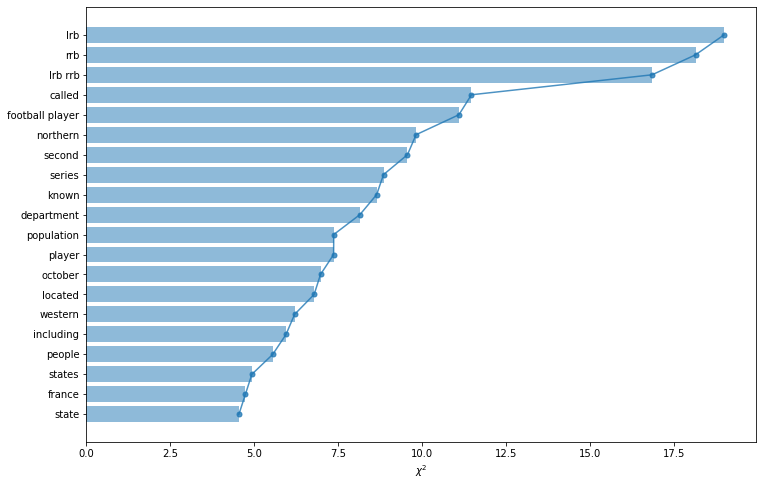

In [ ]:
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
y = tenK_train.label # my add
chi2score = chi2(X_train, y)[0] # from the repo, adjusted for my local var name (the slice [0] is Chi2, [1] is p-val)

scores = list(zip(vectorizer.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

# Section 8 Hyperparameter tuning
- Starting with our baseline LR classifier, and the 10K sample

In [ ]:
X = X_train
y = tenK_train.label

In [ ]:
# #more imports to move to top of sheet
# from sklearn import ensemble
# from sklearn import metrics
# from sklearn import model_selection

#baseline clf lr_clf = LogisticRegression(solver='lbfgs', random_state=42, max_iter=1000) - gives 56.6222

classifier = ensemble.RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED)
param_grid = {
    "n_estimators": np.arange(100,1500, 100),  #[100,200,300,400], #for grid search
    "max_depth": np.arange(1,20),              #[1,3,5,7], # for grid search
    "criterion": ['gini', 'entropy'],
    }

# Grid search, took c.2.4 mins and best result was .575 criterion=entropy, max_depth=7, n_estimators=300, score=0.575, second best: criterion=gini, max_depth=7, n_estimators=200, score=0.574,
model = model_selection.RandomizedSearchCV(
    estimator = classifier,
    #param_grid = param_grid, #for grid search
    param_distributions = param_grid, # for randomizedsearchCV
    n_iter=10, # iterations for randomized
    scoring = 'accuracy',
    verbose = 10,
    n_jobs=1,
    cv=5,
    )

model.fit(X,y)

print (model.best_score_, model.best_estimator_.get_params) 
#This was for the Grid search.
# 0.5667 <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                      #  criterion='gini', max_depth=7, max_features='auto',
                      #  max_leaf_nodes=None, max_samples=None,
                      #  min_impurity_decrease=0.0, min_impurity_split=None,
                      #  min_samples_leaf=1, min_samples_split=2,
                      #  min_weight_fraction_leaf=0.0, n_estimators=400,
                      #  n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      #  warm_start=False)>
# Random search took same time and got better results
# n_estimators=700, max_depth=18, criterion=gini, score=0.580,
# 0.5704 <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                      #  criterion='gini', max_depth=18, max_features='auto',
                      #  max_leaf_nodes=None, max_samples=None,
                      #  min_impurity_decrease=0.0, min_impurity_split=None,
                      #  min_samples_leaf=1, min_samples_split=2,
                      #  min_weight_fraction_leaf=0.0, n_estimators=700,
                      #  n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      #  warm_start=False)>

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1400, max_depth=19, criterion=gini .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1400, max_depth=19, criterion=gini, score=0.568, total=   9.8s
[CV] n_estimators=1400, max_depth=19, criterion=gini .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=19, criterion=gini, score=0.581, total=   8.5s
[CV] n_estimators=1400, max_depth=19, criterion=gini .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=19, criterion=gini, score=0.581, total=   8.5s
[CV] n_estimators=1400, max_depth=19, criterion=gini .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.8s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=19, criterion=gini, score=0.577, total=   8.5s
[CV] n_estimators=1400, max_depth=19, criterion=gini .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.3s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=19, criterion=gini, score=0.568, total=   8.6s
[CV] n_estimators=1400, max_depth=4, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.9s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=4, criterion=entropy, score=0.560, total=   5.0s
[CV] n_estimators=1400, max_depth=4, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   48.9s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=4, criterion=entropy, score=0.576, total=   5.0s
[CV] n_estimators=1400, max_depth=4, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   54.0s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=4, criterion=entropy, score=0.574, total=   5.0s
[CV] n_estimators=1400, max_depth=4, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   59.0s remaining:    0.0s


[CV]  n_estimators=1400, max_depth=4, criterion=entropy, score=0.574, total=   5.0s
[CV] n_estimators=1400, max_depth=4, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=1400, max_depth=4, criterion=entropy, score=0.558, total=   5.0s
[CV] n_estimators=900, max_depth=13, criterion=entropy ...............
[CV]  n_estimators=900, max_depth=13, criterion=entropy, score=0.572, total=   4.9s
[CV] n_estimators=900, max_depth=13, criterion=entropy ...............
[CV]  n_estimators=900, max_depth=13, criterion=entropy, score=0.582, total=   4.8s
[CV] n_estimators=900, max_depth=13, criterion=entropy ...............
[CV]  n_estimators=900, max_depth=13, criterion=entropy, score=0.574, total=   4.8s
[CV] n_estimators=900, max_depth=13, criterion=entropy ...............
[CV]  n_estimators=900, max_depth=13, criterion=entropy, score=0.579, total=   4.8s
[CV] n_estimators=900, max_depth=13, criterion=entropy ...............
[CV]  n_estimators=900, max_depth=13, criterion=entropy, score=0.567, total=   4.7s
[CV] n_estimators=1400, max_depth=18, criterion=gini .................
[CV]  n_estimators=1400, max_depth=18, criterion=gini, score=0.568, to

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.7min finished


0.5748 <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>


In [ ]:
#baseline clf lr_clf = LogisticRegression(solver='lbfgs', random_state=42, max_iter=1000) - gives 56.866

classifier = LogisticRegression(n_jobs=-1, random_state=RANDOM_SEED)
param_grid = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "C":np.logspace(-3,3,20),
    "penalty":["l1","l2","elasticnet"],  
    }

model = model_selection.RandomizedSearchCV(
    estimator = classifier,
    #param_grid = param_grid, #for grid search
    param_distributions = param_grid, # for randomizedsearchCV
    n_iter=10, # iterations for randomized
    scoring = 'accuracy',
    verbose = 10,
    n_jobs=1,
    cv=5,
    )

model.fit(X,y)

print (model.best_score_, model.best_estimator_.get_params) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] solver=newton-cg, penalty=elasticnet, C=0.018329807108324356 ....
[CV]  solver=newton-cg, penalty=elasticnet, C=0.018329807108324356, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=elasticnet, C=0.018329807108324356 ....
[CV]  solver=newton-cg, penalty=elasticnet, C=0.018329807108324356, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=elasticnet, C=0.018329807108324356 ....
[CV]  solver=newton-cg, penalty=elasticnet, C=0.018329807108324356, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=elasticnet, C=0.018329807108324356 ....
[CV]  solver=newton-cg, penalty=elasticnet, C=0.018329807108324356, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=elasticnet, C=0.018329807108324356 ....
[CV]  solver=newton-cg, penalty=elasticnet, C=0.018329807108324356, score=nan, total=   0.0s
[CV] solver=liblinear, penalty=l2, C=0.07847599703514611 .............
[CV]  solver=liblinear, penalty=l2, C=0.07847599

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {

[CV]  solver=saga, penalty=elasticnet, C=112.88378916846884, score=nan, total=   0.0s
[CV] solver=saga, penalty=elasticnet, C=112.88378916846884 ...........
[CV]  solver=saga, penalty=elasticnet, C=112.88378916846884, score=nan, total=   0.0s
[CV] solver=saga, penalty=elasticnet, C=112.88378916846884 ...........
[CV]  solver=saga, penalty=elasticnet, C=112.88378916846884, score=nan, total=   0.0s
[CV] solver=saga, penalty=elasticnet, C=112.88378916846884 ...........
[CV]  solver=saga, penalty=elasticnet, C=112.88378916846884, score=nan, total=   0.0s
[CV] solver=liblinear, penalty=l2, C=54.555947811685144 ..............
[CV]  solver=liblinear, penalty=l2, C=54.555947811685144, score=0.563, total=   0.0s
[CV] solver=liblinear, penalty=l2, C=54.555947811685144 ..............
[CV]  solver=liblinear, penalty=l2, C=54.555947811685144, score=0.586, total=   0.0s
[CV] solver=liblinear, penalty=l2, C=54.555947811685144 ..............
[CV]  solver=liblinear, penalty=l2, C=54.555947811685144, sc

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
